# <center>CHE1147 Data Mining in Engineering</center>

## <center>Assignment 5</center>


#### <div style="text-align: right">Bowen Xu</div>
#### <div style="text-align: right">1006411786</div>    

In [1]:
import  pandas as pd 
import  numpy as np
import  matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, f1_score

## 1. Supervised Learning

### 1.1 Import the monthly and annual data and join

In [2]:
#read kaggle data
kaggle = pd.read_csv('Retail_Data_Response.csv')

In [3]:
#read annual data
annual_features = pd.read_excel('annual_features.xlsx')
annual_day_of_week_counts_pivot = pd.read_excel('annual_day_of_week_counts_pivot.xlsx')

In [4]:
df_annual = pd.merge(annual_features, annual_day_of_week_counts_pivot,on='customer_id').merge(kaggle,on='customer_id')

In [5]:
#read monthly data
mth_rolling_features = pd.read_excel('mth_rolling_features.xlsx')
mth_day_counts = pd.read_excel('mth_day_counts.xlsx')
days_since_last_txn = pd.read_excel('days_since_last_txn.xlsx')

In [6]:
mth_rolling_features.drop('Unnamed: 0',axis=1,inplace=True)
mth_day_counts.drop('Unnamed: 0',axis=1,inplace=True)
days_since_last_txn.drop('Unnamed: 0',axis=1,inplace=True)

In [7]:
df_monthly = pd.merge(mth_rolling_features, mth_day_counts,on=['CLNT_NO','ME_DT'])\
               .merge(days_since_last_txn,on=['CLNT_NO','ME_DT'])\
               .merge(kaggle.rename(columns={'customer_id':'CLNT_NO'}),on='CLNT_NO')

<div style='color:purple'> I dropped the rows which have missing values since logistic regression model won't take missing values as the input features. Those missing values are caused by the rolling features from A3, therefore, it makes sense to me to drop those rows instead of filling them with 0s.

In [8]:
df_monthly.dropna(inplace=True)

### 1.2 Steps for each method

##### &emsp;&emsp;&emsp; - 1. Separate the inputs X and the output y in two data frames.

In [9]:
X_annual = df_annual.drop(['response','customer_id'], axis=1)
y_annual = df_annual['response'].astype(int)

X_monthly = df_monthly.drop(['response','CLNT_NO','ME_DT'], axis=1)
y_monthly = df_monthly['response'].astype(int)

##### &emsp;&emsp;&emsp; - 2. plit the data in train and test set. Use a test size value of 2/3 and set the random state equal to 1147 for consistency (i.e. the course code value). Use the following names for consistency.

In [10]:
X_train_annual, X_test_annual, y_train_annual, y_test_annual = train_test_split(X_annual, y_annual, test_size=2/3, random_state=1147)

X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(X_monthly, y_monthly, test_size=2/3, random_state=1147)

##### &emsp;&emsp;&emsp; - 3. Pre-process (if necessary for the method).

In [11]:
scaler_annual = StandardScaler()
X_train_annual_scaled = scaler_annual.fit_transform(X_train_annual)

scaler_monthly = StandardScaler()
X_train_monthly_scaled = scaler_monthly.fit_transform(X_train_monthly)

In [12]:
X_test_annual_scaled = scaler_annual.transform(X_test_annual)

X_test_monthly_scaled = scaler_monthly.transform(X_test_monthly)

##### &emsp;&emsp;&emsp; - 4. Fit the training dataset and optimize the hyperparameters of the method.

##### &emsp;&emsp;&emsp; - 5. Plot coefficient values or feature importance.

##### &emsp;&emsp;&emsp; - 6. Plot probability distribution for test set.

##### &emsp;&emsp;&emsp; - 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

##### &emsp;&emsp;&emsp; - 8. Plot decision boundary for top 2 features.

## <center>Model Implementation

### Basic Structure
    
    
- <b>Helper Functions</b>

    - plot_train_test_curves: plot the accuracy and AUC curves for both training and test data;
    - plot_test_distribution: plot the probability of predicted results on the test dataset;
    - plot_confusion_matrix: plot the confusion matrix for the ground-truth and predicted results on test set;
    - plot_roc: plot ROC curves for both training and test set;
    - plot_decision_boundary: plot decision boundary for the top 2 features.
    
    
- <b>Annual Prediction</b>: Using three models to make predictions for annual dataset


- <b>Monthly Prediction</b>: Using three models to make predictions for monthly dataset

### Overall Methodology and Justification

- Since the both annual and monthly datasets are highly imbalanced (too few positive responses), I used <b>class_weight='balanced'</b> attribute for every model to get meaningful results from both classes; in terms of metric to compare models for an umbalanced dataset, accuracy will not be a proper metric to evaluate model since the model can simply regard all samples to the negative cases in order to get higher accuracy, therefore, I used <b>F1 score</b> which can combine both the precision and recall for selecting the best hyperparameter as well as the AUC scores.


- The most important hyperparameter is tuned for each model such as 'C' for logistic regression and 'max_depth' for both decision tree and random forest. After the best hyperparameter is selected, that value will be sub into the model again and get all the output graphsa and precision and recall values.

### <center>Helper Functions

In [13]:
def plot_train_test_curves(performance_df, x_name):
    
    fig_1 = plt.figure(figsize=(24,7))
    fig_1_a = plt.subplot(131)
    ax1 = performance_df.plot(x = x_name, y = 'ACCURACY_TRAIN', ax = fig_1_a, style = 'o-', markersize =7)
    ax2 = performance_df.plot(x = x_name, y = 'ACCURACY_TEST', ax = fig_1_a, style = 'o-', markersize =7)
    ax1.set_ylabel("Normalized Accuracy (%)")
    ax1.set_xlabel("Hyperparameter")

    fig_1_b = plt.subplot(132)
    ax2 = performance_df.plot(x = x_name, y = 'AUC_TRAIN', ax = fig_1_b, style = 'o-', markersize =7)
    ax2 = performance_df.plot(x = x_name, y = 'AUC_TEST', ax = fig_1_b, style = 'o-', markersize =7)
    ax2.set_xlabel("Hyperparameter")
    ax2.set_ylabel("Area Under the Curve (AUC)")
    
    fig_1_c = plt.subplot(133)
    ax3 = performance_df.plot(x = x_name, y = 'F1_TRAIN', ax = fig_1_c, style = 'o-', markersize =7)
    ax3 = performance_df.plot(x = x_name, y = 'F1_TEST', ax = fig_1_c, style = 'o-', markersize =7)
    ax3.set_xlabel("Hyperparameter")
    ax3.set_ylabel("F1 Score")

    plt.show()

In [14]:
def plot_test_distribution(y_test_prob):
    plt.hist(100*y_test_prob[:,1], bins=70)
    plt.title('Distribution of probabilities')
    plt.xlabel('Probability to positive response (%)')
    plt.ylabel('Counts of clients')

In [15]:
def plot_confusion_matrix(y_test, y_test_predicted):
    
    cm = confusion_matrix(y_test, y_test_predicted)
    
    precision = cm[1,1]/cm.sum(axis=0)[1]
    recall = cm[1,1]/cm.sum(axis=1)[1]
    
    print('Precision:', precision)
    print('Recall',recall)
    
    classNames = ['Negative','Positive']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 10,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

In [16]:
def plot_roc(y_train, scores_train, y_test, scores_test, model_name):
    
    fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    auc_train = auc(fpr_train, tpr_train)
    auc_test  = auc(fpr_test, tpr_test)

    # Plotting
    plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
    plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
    plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
    plt.ylim([0,1.0])
    plt.xlim([0,1.0])
    plt.title('{} ROC curves'.format(model_name))
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.legend()

In [17]:
def plot_decision_boundary(best_model, feat1, feat2, X_train_scaled, X, y_train):
    
    print('\nTop 2 features are:',X.columns[[feat1, feat2]])
    min_value1, min_value2 = np.floor(X_train_scaled.min(axis=0)[[feat1, feat2]])
    max_value1, max_value2 = np.ceil(X_train_scaled.max(axis=0)[[feat1, feat2]])
    step1, step2 = (max_value1-min_value1)/10, (max_value2-min_value2)/10
    xx, yy = np.mgrid[min_value1:max_value1:step1, min_value2:max_value2:step2]
    grid = np.c_[xx.ravel(), yy.ravel()]
    median_inputs = np.ones((100, X.shape[1])) * np.median(X_train_scaled, axis=0)
    median_inputs[:,feat1] = grid[:,0]
    median_inputs[:,feat2] = grid[:,1]
    
    probs = best_model.predict_proba(median_inputs)[:, 1].reshape(xx.shape)
    
    f, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                          vmin=0, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    ax.scatter(X_train_scaled[50:,feat1], X_train_scaled[50:,feat2], c=y_train[50:], s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)

    ax.set(aspect="auto",
           xlim=(min_value1, max_value1), ylim=(min_value2, max_value2),
           xlabel="{} scaled".format(X.columns[feat1]), ylabel="{} scaled".format(X.columns[feat2]))

## <center style='color:blue'>Annual Prediction

### <center>Logistic Regression
    

In [18]:
def find_best_lr(X_train, y_train, X_test, y_test):
    
    '''Using for loop to tune the hyperparamter C for logistic regression
    Attributes: 
        X_train: training dataset
        y_train: ground truth of the training data
        X_test: test dataset
        y_test: ground truth of the test data
    Return:
        A dataframe which includes all metrics
    '''
    
    Cs = [0.0025, 0.005, 0.01, 0.05, 0.1, 1, 10]
    estimator_c, accuracy_train, accuracy_test, precisions, recalls, f1_train, f1_test, auc_train, auc_test = [],[],[],[],[],[],[],[],[]


    for i in range(len(Cs)):
        # Define and fit
        c = Cs[i]
        estimator_c.append(LogisticRegression(penalty='l1', C = c, solver='liblinear',class_weight='balanced',random_state=1147))
        estimator_c[i].fit(X_train, y_train)

        # Score train and test set
        scores_train = estimator_c[i].predict_proba(X_train)[:,1] 
        scores_test  = estimator_c[i].predict_proba(X_test)[:,1]  

        # Predict the class of training and test set
        y_train_predicted = estimator_c[i].predict(X_train)
        y_test_predicted = estimator_c[i].predict(X_test)

        # Calculate training and test accuracy at every iteration and append
        accuracy_train.append(100*accuracy_score(y_train, y_train_predicted, normalize = True))
        accuracy_test.append(100*accuracy_score(y_test, y_test_predicted, normalize = True))
        
        # Calculate training and test F1 score at every iteration and append
        f1_train.append(100*f1_score(y_train, y_train_predicted))
        f1_test.append(100*f1_score(y_test, y_test_predicted))

        # Calculate precision and recall for test set
        precisions.append(precision_score(y_test, y_test_predicted))
        recalls.append(recall_score(y_test, y_test_predicted))

        # ROC Calc for training and test set
        fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
        fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)

        # Calculate the AUCs
        auc_train.append(auc(fpr_train, tpr_train))
        auc_test.append(auc(fpr_test, tpr_test))

    # Generate a summary table for all metrics
    performance_dictionary = {'ACCURACY_TRAIN': accuracy_train, 
                              'ACCURACY_TEST': accuracy_test, 
                              'F1_TRAIN': f1_train, 
                              'F1_TEST': f1_test,
                              'PRECISION': precisions,
                              'RECALL': recalls,
                              'AUC_TRAIN': auc_train,
                              'AUC_TEST': auc_test}
    performance_df = pd.DataFrame(performance_dictionary)
    performance_df['C'] = Cs
    
    return performance_df

In [19]:
lr_performance_annual = find_best_lr(X_train_annual_scaled, y_train_annual, X_test_annual_scaled, y_test_annual)

In [20]:
lr_performance_annual['logc'] = np.log(lr_performance_annual['C'])

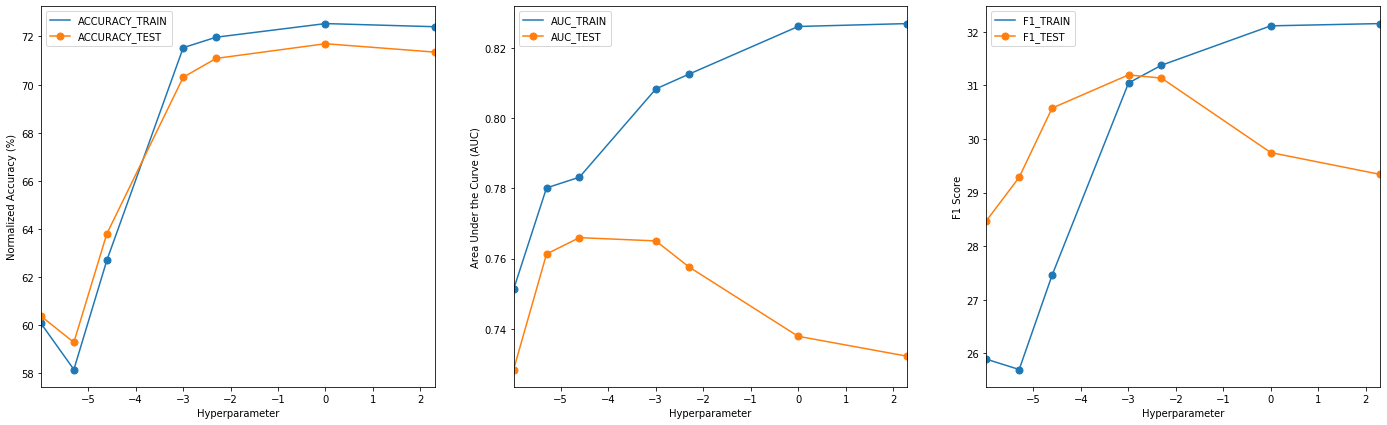

In [21]:
plot_train_test_curves(lr_performance_annual,'logc')

In [22]:
lr_performance_annual

,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST,C,logc
0,60.069747,60.370370,25.889968,28.470311,0.173040,0.802661,0.751271,0.728438,0.0025,-5.991465
1,58.151700,59.281046,25.696594,29.284904,0.176551,0.858093,0.780105,0.761305,0.0050,-5.298317
2,62.685266,63.790850,27.457627,30.576441,0.188369,0.811530,0.783156,0.765956,0.0100,-4.605170
3,71.534438,70.305011,31.045407,31.196365,0.201961,0.685144,0.808275,0.765027,0.0500,-2.995732
4,71.970357,71.089325,31.376734,31.136482,0.203252,0.665188,0.812453,0.757650,0.1000,-2.302585
5,72.537053,71.699346,32.112069,29.745809,0.196710,0.609756,0.826037,0.737886,1.0000,0.000000
6,72.406277,71.350763,32.154341,29.339065,0.193617,0.605322,0.826864,0.732207,10.0000,2.302585


#### <div style='color:purple'>By looking at the AUC curves and F1 curves for both training and test dataset, it clearly shows that the AUC score for test set is higher and F1 score is relatively higher when C=0.01 or C=0.05. However, the training AUC and is much higher at C=0.05 than C=0.01 which may indicate that C=0.05 better fit the data and may leared more information from the training set, also the F1 score is the highest at C=0.05, therefore, I selected 0.05 as the best C for this logistic regression model.

In [23]:
def lr(X_train, X_test, y_train, y_test, X, best_param):
    
    '''Using the best hyperparamter C for logistic regression and plot the feature coefficients (sorted)
    Attributes: 
        X_train: training dataset
        y_train: ground truth of the training data
        X_test: test dataset
        y_test: ground truth of the test data
        X: original trainig dataset with columns names (for plotting feature importance)
        best_param: best C got from above
    Return:
        best_model: a logistic regression model with the best hyperparameter after fitting
        y_test_pred: predictions from test dataset
        y_test_prob: predicted probabilities for test dataset
        scores_train: predicted probabilities of class 1 from training dataset
        scores_test: predicted probabilities of class 1 from test dataset
    '''
        
    best_model = LogisticRegression(penalty='l1',solver='liblinear', C=best_param, class_weight='balanced',random_state=1147)
    best_model.fit(X_train, y_train)
    m = best_model.coef_
    
    #plot coefficient values
    plt.figure(figsize=(15,9))
    indices = np.argsort(abs(m[0]))[::-1]
    names = [X.columns[i] for i in indices]
    print('The indices for top 2 features are: ',indices[:2])
    plt.title("Model Coefficients")
    plt.bar(range(X.shape[1]), m[0][indices])
    plt.xticks(range(X.shape[1]), names, rotation=90)
    plt.show()
    
    
    #prediction and predicted probability
    y_test_pred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)
    
    #scores for ROC curves
    scores_train = best_model.predict_proba(X_train)[:, 1]
    scores_test = best_model.predict_proba(X_test)[:, 1]
        
    return best_model, y_test_pred, y_test_prob, scores_train, scores_test

The indices for top 2 features are:  [27 38]


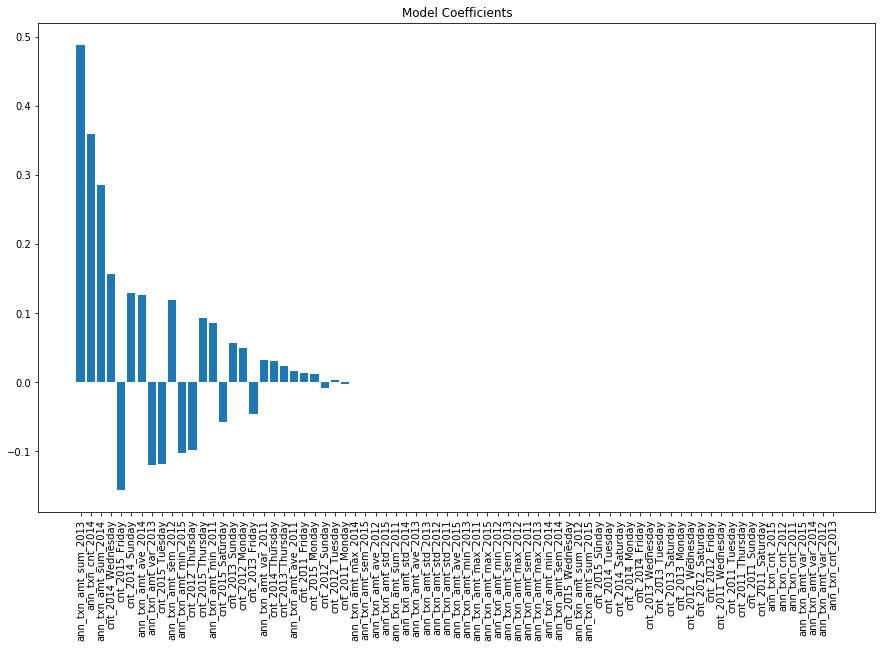

In [24]:
best_model, y_test_pred, y_test_prob, scores_train, scores_test = lr(X_train_annual_scaled, X_test_annual_scaled, y_train_annual, y_test_annual, X_train_annual, 0.05)

Precision: 0.2019607843137255
Recall 0.6851441241685144

Top 2 features are: Index(['ann_txn_amt_sum_2013', 'ann_txn_cnt_2014'], dtype='object')


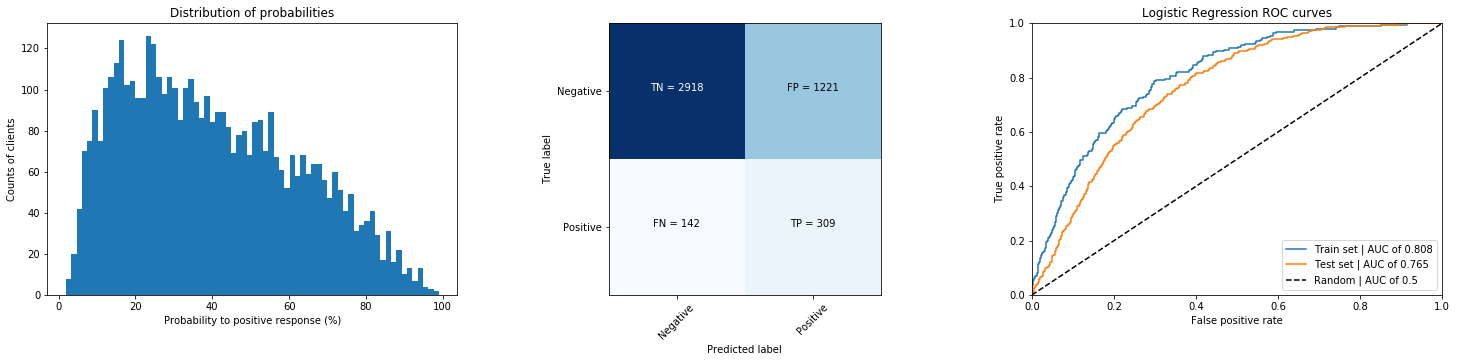

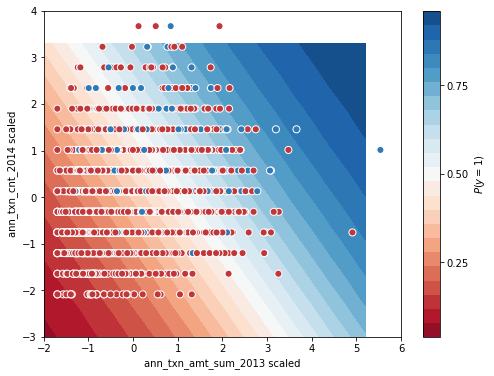

In [25]:
fig = plt.figure(figsize=(25,5))
fig.add_subplot(1,3,1)
plot_test_distribution(y_test_prob)

fig.add_subplot(1,3,2)
plot_confusion_matrix(y_test_annual.values, y_test_pred)

fig.add_subplot(1,3,3)
plot_roc(y_train_annual, scores_train, y_test_annual, scores_test, 'Logistic Regression')

plot_decision_boundary(best_model, 27, 38, X_train_annual_scaled, X_train_annual, y_train_annual)

### <center>Decision Tree

In [26]:
def find_best_dt(X_train, y_train, X_test, y_test):
    
    max_depth_range = range(2, 11)
    estimator_max_depth, accuracy_train, accuracy_test, precisions, recalls, f1_train, f1_test, auc_train, auc_test = [],[],[],[],[],[],[],[],[]

    for i in max_depth_range:
        # Define and fit
        estimator_max_depth.append(DecisionTreeClassifier(max_depth = i, random_state=1147, class_weight='balanced'))
        estimator_max_depth[i-2].fit(X_train, y_train)
        
        # Score train and test set 
        scores_train = estimator_max_depth[i-2].predict_proba(X_train)[:,1] 
        scores_test  = estimator_max_depth[i-2].predict_proba(X_test)[:,1]  
        
        # Predict the class of train and test set
        y_train_predicted = estimator_max_depth[i-2].predict(X_train)
        y_test_predicted = estimator_max_depth[i-2].predict(X_test)
        
        # Calculate training and test accuracy at every iteration and append
        accuracy_train.append(100*accuracy_score(y_train, y_train_predicted, normalize = True))
        accuracy_test.append(100*accuracy_score(y_test, y_test_predicted, normalize = True))
        
        # Calculate training and test F1 score at every iteration and append
        f1_train.append(100*f1_score(y_train, y_train_predicted))
        f1_test.append(100*f1_score(y_test, y_test_predicted))
        
        # Calculate precision and recall
        precisions.append(precision_score(y_test, y_test_predicted))
        recalls.append(recall_score(y_test, y_test_predicted))
        
        # ROC Calc Train and test set 
        fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
        fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
        
        # Calculate the AUCs
        auc_train.append(auc(fpr_train, tpr_train))
        auc_test.append(auc(fpr_test, tpr_test))
    
    performance_dictionary = {'ACCURACY_TRAIN': accuracy_train, 
                              'ACCURACY_TEST': accuracy_test,
                              'F1_TRAIN': f1_train, 
                              'F1_TEST': f1_test,
                              'PRECISION': precisions,
                              'RECALL': recalls,
                              'AUC_TRAIN': auc_train,
                              'AUC_TEST': auc_test}
    performance_df = pd.DataFrame(performance_dictionary)
    performance_df['MAX_DEPTH'] = max_depth_range
    return performance_df

In [27]:
dt_performance_annual = find_best_dt(X_train_annual_scaled, y_train_annual, X_test_annual_scaled, y_test_annual)

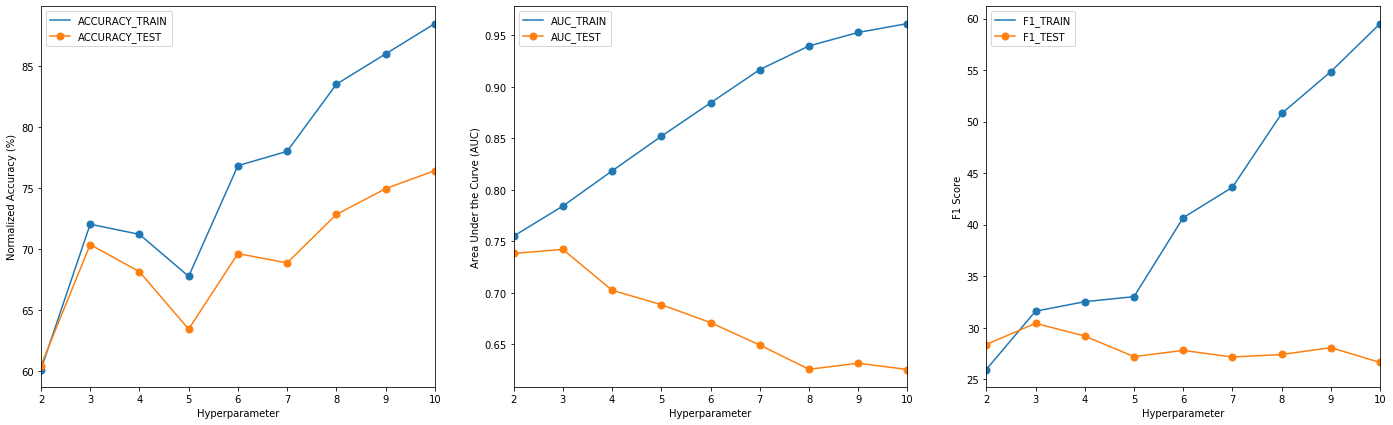

In [28]:
plot_train_test_curves(dt_performance_annual,'MAX_DEPTH')

In [29]:
dt_performance_annual

,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST,MAX_DEPTH
0,60.156931,60.479303,25.931929,28.357030,0.172513,0.796009,0.755100,0.738316,2
1,72.057541,70.392157,31.590181,30.414747,0.197736,0.658537,0.784239,0.742226,3
2,71.229294,68.169935,32.515337,29.180805,0.186725,0.667406,0.818369,0.702593,4
3,67.785527,63.464052,33.000907,27.181937,0.169006,0.694013,0.851948,0.688598,5
4,76.852659,69.651416,40.670391,27.786418,0.181326,0.594235,0.884363,0.671177,6
5,78.029643,68.888889,43.624161,27.142857,0.176276,0.589800,0.916638,0.649414,7
6,83.522232,72.854031,50.781250,27.389277,0.185771,0.521064,0.939633,0.625903,8
7,86.006975,74.967320,54.852321,28.052599,0.195462,0.496674,0.952722,0.631791,9
8,88.491718,76.448802,59.509202,26.612356,0.191781,0.434590,0.961312,0.625688,10


#### <div style='color:purple'>By looking at the AUC curves and F1 score curves for both training and test dataset: at max_depth=3, the AUC_TEST and F1_TEST are both the highest, therefore, I used max_depth=3 as the best hyperparameter for this decision tree model.

In [30]:
def dt(X_train, X_test, y_train, y_test, X, best_param):
         
    best_model = DecisionTreeClassifier(max_depth=best_param, random_state=0, class_weight='balanced')
    best_model.fit(X_train, y_train)
    
    #plot feature importance
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    print('The indices for top 2 features are: ', indices[:2])
    names = [X.columns[i] for i in indices]
    plt.figure(figsize=(15,9))
    plt.title("Feature Importance")
    plt.bar(range(X.shape[1]), importances[indices])
    plt.xticks(range(X.shape[1]), names, rotation=90)
    plt.show()
    
    #prediction and predicted probability
    y_test_pred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)
    
    #scores for ROC curves
    scores_train = best_model.predict_proba(X_train)[:, 1]
    scores_test = best_model.predict_proba(X_test)[:, 1]
        
    return best_model, y_test_pred, y_test_prob, scores_train, scores_test

The indices for top 2 features are:  [28 27]


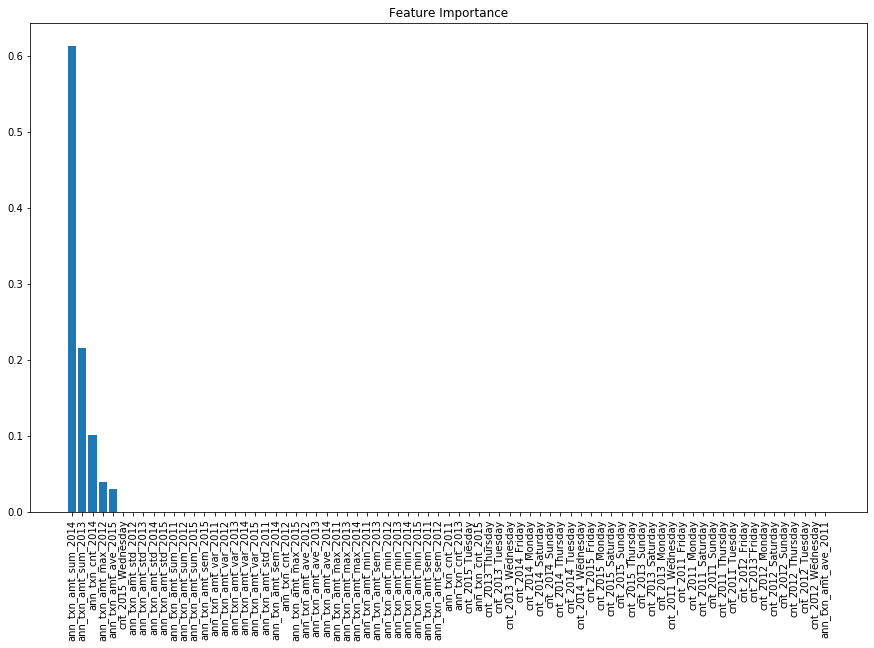

In [31]:
best_model, y_test_pred, y_test_prob, scores_train, scores_test = dt(X_train_annual_scaled, X_test_annual_scaled, y_train_annual, y_test_annual, X_train_annual,3)

Precision: 0.1977363515312916
Recall 0.6585365853658537

Top 2 features are: Index(['ann_txn_amt_sum_2014', 'ann_txn_amt_sum_2013'], dtype='object')


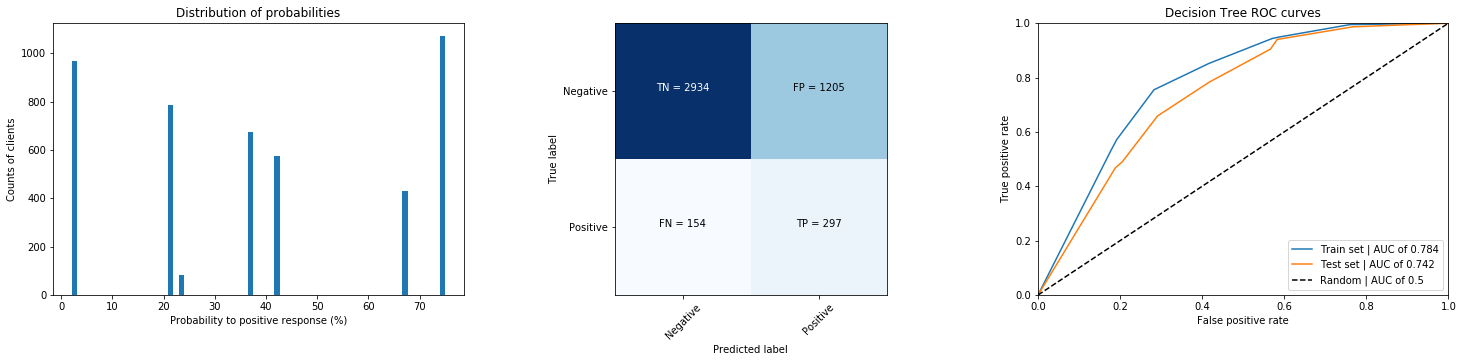

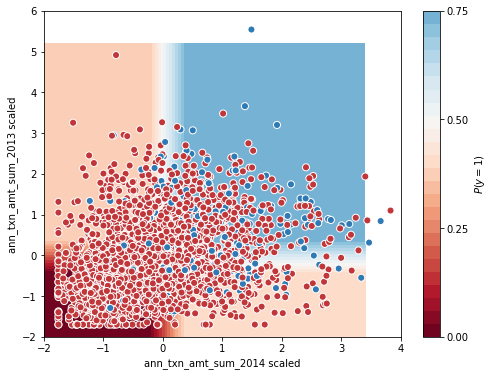

In [32]:
fig = plt.figure(figsize=(25,5))
fig.add_subplot(1,3,1)
plot_test_distribution(y_test_prob)

fig.add_subplot(1,3,2)
plot_confusion_matrix(y_test_annual.values, y_test_pred)

fig.add_subplot(1,3,3)
plot_roc(y_train_annual, scores_train, y_test_annual, scores_test, 'Decision Tree')

plot_decision_boundary(best_model, 28, 27, X_train_annual_scaled, X_train_annual, y_train_annual)

### <center>Random Forest

In [33]:
def find_best_rf(X_train, y_train, X_test, y_test):
    
    max_depth_range = range(2,20)
    estimator_max_depth, accuracy_train, accuracy_test, precisions, recalls, f1_train, f1_test, auc_train, auc_test = [],[],[],[],[],[],[],[],[]

    for i in max_depth_range:
        # Define and fit
        estimator_max_depth.append(RandomForestClassifier(max_depth = i,class_weight='balanced', random_state=1147))
        estimator_max_depth[i-2].fit(X_train, y_train)
        
        # Score train and test set 
        scores_train = estimator_max_depth[i-2].predict_proba(X_train)[:,1] 
        scores_test  = estimator_max_depth[i-2].predict_proba(X_test)[:,1]  
        
        # Predict the class of test set
        y_train_predicted = estimator_max_depth[i-2].predict(X_train)
        y_test_predicted = estimator_max_depth[i-2].predict(X_test)
        
        # Calculate training and test accuracy at every iteration and append
        accuracy_train.append(100*accuracy_score(y_train, y_train_predicted, normalize = True))
        accuracy_test.append(100*accuracy_score(y_test, y_test_predicted, normalize = True))
        
        # Calculate training and test F1 score at every iteration and append
        f1_train.append(100*f1_score(y_train, y_train_predicted))
        f1_test.append(100*f1_score(y_test, y_test_predicted))
        
        # Calculate precision and recall
        precisions.append(precision_score(y_test, y_test_predicted))
        recalls.append(recall_score(y_test, y_test_predicted))
        
        # ROC Calc trianing and test dataset
        fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
        fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
        
        # Calculate the AUCs
        auc_train.append(auc(fpr_train, tpr_train))
        auc_test.append(auc(fpr_test, tpr_test))
    

    performance_dictionary = {'ACCURACY_TRAIN': accuracy_train, 
                              'ACCURACY_TEST': accuracy_test, 
                              'F1_TRAIN': f1_train, 
                              'F1_TEST': f1_test, 
                              'PRECISION': precisions,
                              'RECALL': recalls,
                              'AUC_TRAIN': auc_train,
                              'AUC_TEST': auc_test}
    performance_df = pd.DataFrame(performance_dictionary)
    performance_df['MAX_DEPTH'] = max_depth_range
    return performance_df

In [34]:
rf_performance_annual = find_best_rf(X_train_annual_scaled, y_train_annual, X_test_annual_scaled, y_test_annual)

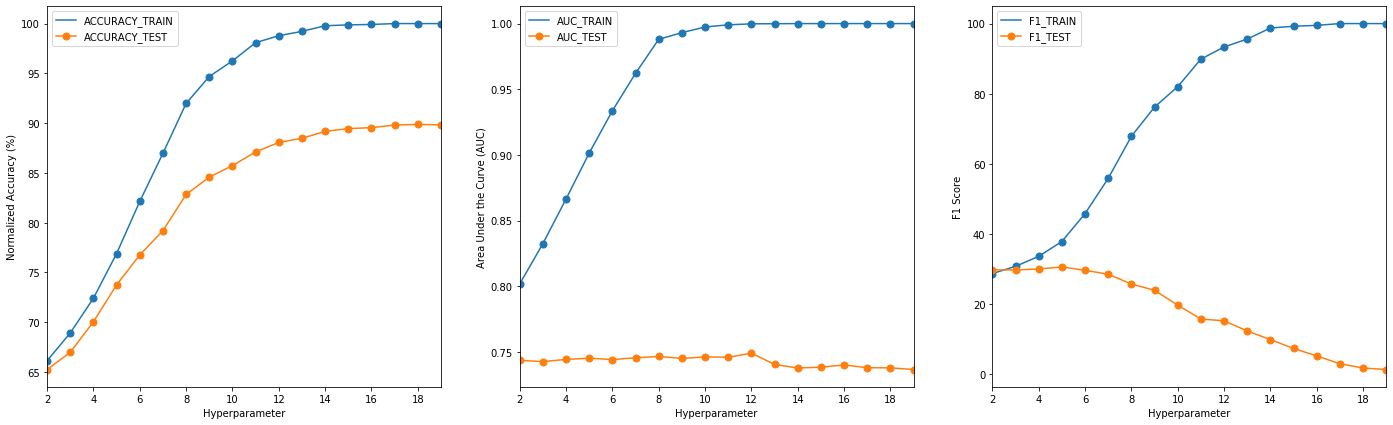

In [35]:
plot_train_test_curves(rf_performance_annual,'MAX_DEPTH')

In [36]:
rf_performance_annual

,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST,MAX_DEPTH
0,66.129032,65.250545,28.650138,29.704716,0.185369,0.747228,0.801782,0.743527,2
1,68.918919,66.971678,30.709427,29.684601,0.187683,0.709534,0.832442,0.742638,3
2,72.406277,70.043573,33.578174,29.954152,0.194444,0.651885,0.866452,0.744270,4
3,76.896251,73.747277,37.793427,30.547550,0.206386,0.587583,0.901446,0.745206,5
4,82.127289,76.753813,45.767196,29.570957,0.210526,0.496674,0.933608,0.744154,6
5,86.965998,79.193900,55.834564,28.464419,0.214932,0.421286,0.962194,0.745514,7
6,91.979076,82.832244,67.832168,25.660377,0.223317,0.301552,0.988026,0.746536,8
7,94.681779,84.575163,76.171875,23.870968,0.231733,0.246120,0.993118,0.745020,9
8,96.251090,85.729847,82.008368,19.631902,0.219780,0.177384,0.997408,0.746198,10
9,98.081953,87.102397,89.861751,15.669516,0.219124,0.121951,0.999052,0.745923,11


#### <div style='color:purple'>By looking at the AUC curves and F1 score curves for both training and test dataset: at max_depth=5, the F1 score has the highest value for the test set and the curve starts to decline when the trees get deeper than 5, and AUC_TEST keeps constant and have no further improvements as the depth gets larger. Therefore, max_depth=5 is a proper value for this random forest model.

In [38]:
def rf(X_train, X_test, y_train, y_test, X,best_param):
        
    best_model = RandomForestClassifier(max_depth = best_param, random_state=1147, class_weight='balanced')
    best_model.fit(X_train, y_train)
    
    #plot feature importance
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    print('The indices for top 2 features are: ', indices[:2])
    names = [X.columns[i] for i in indices]
    plt.figure(figsize=(15,9))
    plt.title("Feature Importance")
    plt.bar(range(X.shape[1]), importances[indices])
    plt.xticks(range(X.shape[1]), names, rotation=90)
    plt.show()
    
    #prediction and predicted probability
    y_test_pred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)
    
    #scores for ROC curves
    scores_train = best_model.predict_proba(X_train)[:, 1]
    scores_test = best_model.predict_proba(X_test)[:, 1]
        
    return best_model, y_test_pred, y_test_prob, scores_train, scores_test

The indices for top 2 features are:  [38 28]


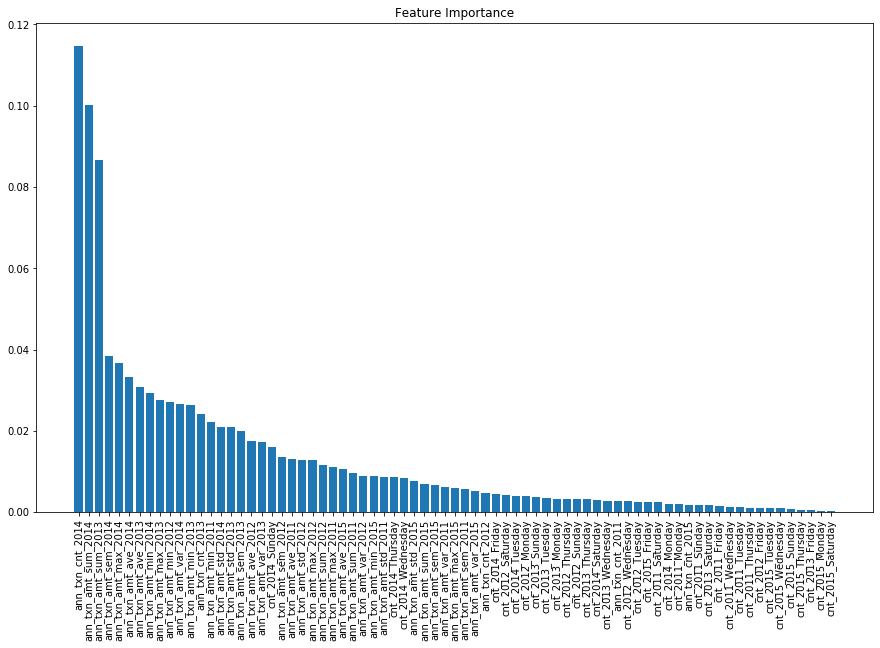

In [39]:
best_model, y_test_pred, y_test_prob, scores_train, scores_test = rf(X_train_annual_scaled, X_test_annual_scaled, y_train_annual, y_test_annual, X_train_annual,5)

Precision: 0.20638629283489096
Recall 0.5875831485587583

Top 2 features are: Index(['ann_txn_cnt_2014', 'ann_txn_amt_sum_2014'], dtype='object')


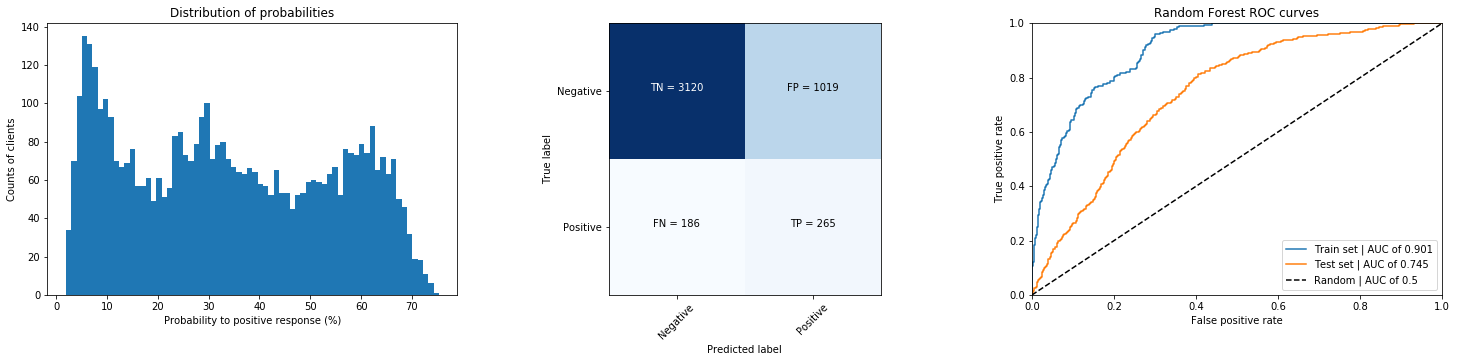

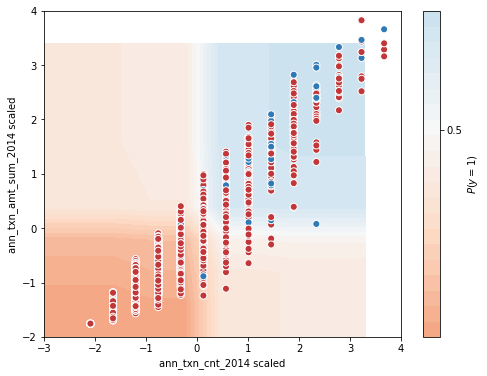

In [40]:
fig = plt.figure(figsize=(25,5))
fig.add_subplot(1,3,1)
plot_test_distribution(y_test_prob)

fig.add_subplot(1,3,2)
plot_confusion_matrix(y_test_annual.values, y_test_pred)

fig.add_subplot(1,3,3)
plot_roc(y_train_annual, scores_train, y_test_annual, scores_test, 'Random Forest')

plot_decision_boundary(best_model, 38, 28, X_train_annual_scaled, X_train_annual, y_train_annual)

## <center style='color:blue'>Monthly Prediction

### <center>Logistic Regression

In [41]:
lr_performance_monthly = find_best_lr(X_train_monthly_scaled, y_train_monthly, X_test_monthly_scaled, y_test_monthly)

In [42]:
lr_performance_monthly['logc'] = np.log(lr_performance_monthly['C'])

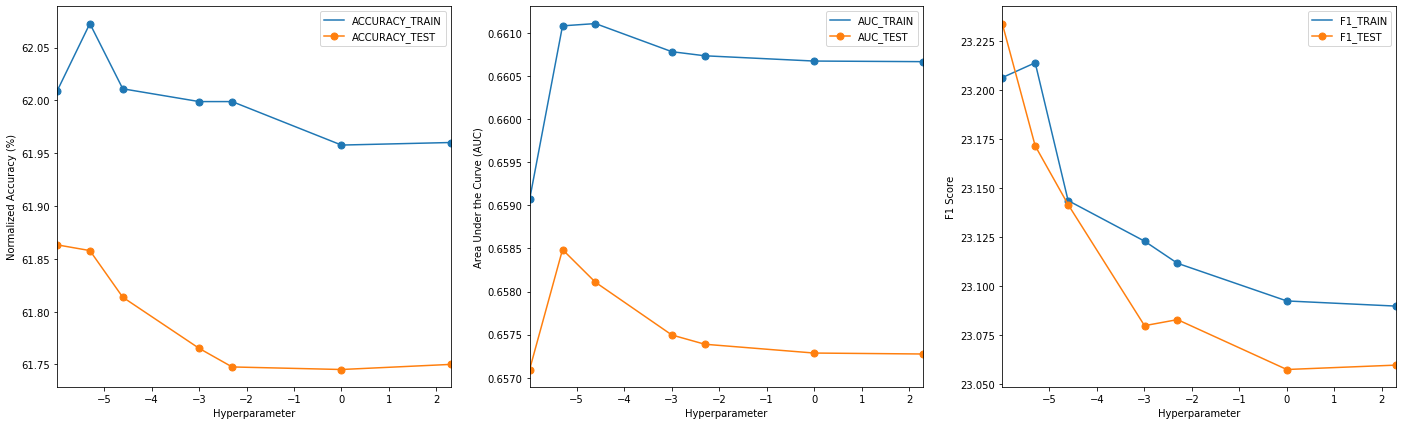

In [43]:
plot_train_test_curves(lr_performance_monthly, 'logc')

In [44]:
lr_performance_monthly

,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST,C,logc
0,62.008522,61.863258,23.206421,23.233997,0.143452,0.610826,0.659069,0.657094,0.0025,-5.991465
1,62.072681,61.857810,23.213979,23.171549,0.143089,0.608776,0.661086,0.658487,0.0050,-5.298317
2,62.010943,61.813626,23.143613,23.141583,0.142879,0.608456,0.661112,0.658107,0.0100,-4.605170
3,61.998838,61.765204,23.122888,23.079733,0.142481,0.607111,0.660786,0.657495,0.0500,-2.995732
4,61.998838,61.747652,23.111590,23.082821,0.142484,0.607495,0.660738,0.657388,0.1000,-2.302585
5,61.957680,61.745230,23.092360,23.057351,0.142335,0.606662,0.660677,0.657285,1.0000,0.000000
6,61.960101,61.750073,23.089725,23.059597,0.142352,0.606662,0.660670,0.657274,10.0000,2.302585


#### <div style='color:purple'>By looking at the AUC curves and F1 score curves for both training and test dataset: the test F1 score is decreasing since C=0.0025 and seem no return back when C gets larger. However, in the AUC curve, at C=0.005, AUC_TEST is the highest and the curve starts to decrease after that, therefore, 0.005 will be a proper value for C in this model.

The indices for top 2 features are:  [15 14]


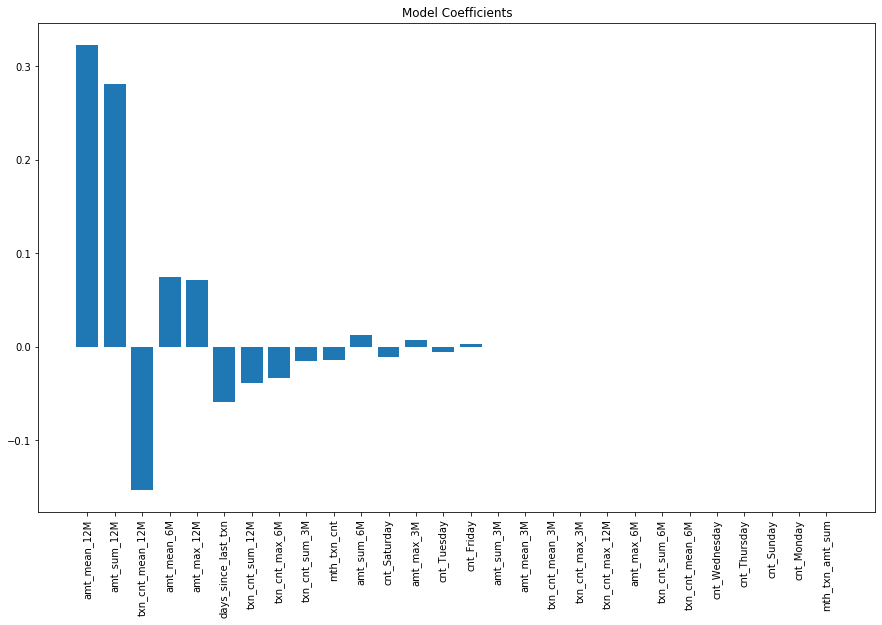

In [45]:
best_model, y_test_pred, y_test_prob, scores_train, scores_test = lr(X_train_monthly_scaled, X_test_monthly_scaled, y_train_monthly, y_test_monthly, X_train_monthly, 0.005)

Precision: 0.1430894553777122
Recall 0.6087764253683536

Top 2 features are: Index(['amt_mean_12M', 'amt_sum_12M'], dtype='object')


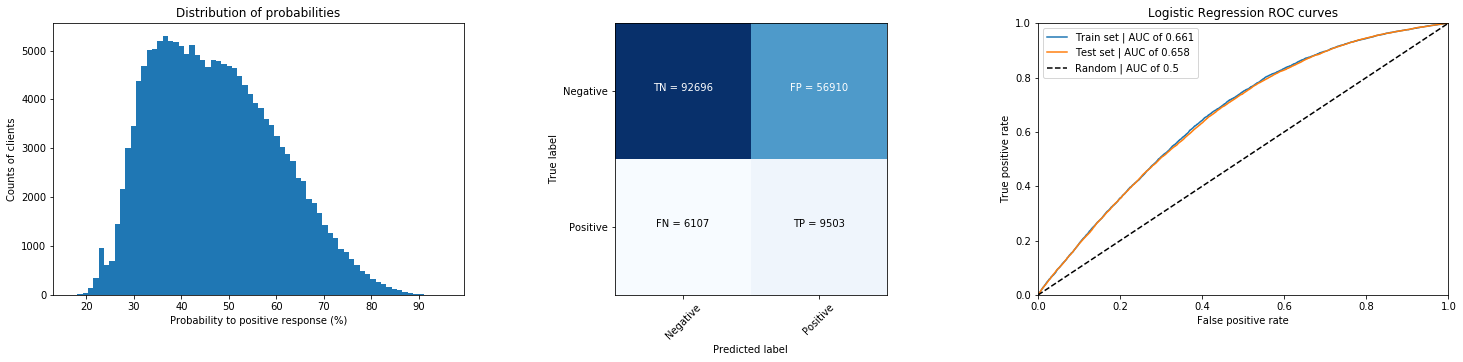

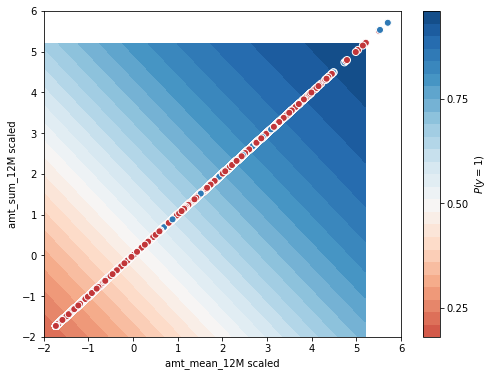

In [46]:
fig = plt.figure(figsize=(25,5))
fig.add_subplot(1,3,1)
plot_test_distribution(y_test_prob)

fig.add_subplot(1,3,2)
plot_confusion_matrix(y_test_monthly.values, y_test_pred)

fig.add_subplot(1,3,3)
plot_roc(y_train_monthly, scores_train, y_test_monthly, scores_test, 'Logistic Regression')

plot_decision_boundary(best_model, 15,14, X_train_monthly_scaled, X_train_monthly, y_train_monthly)

### <center>Decision Tree

In [47]:
dt_performance_monthly = find_best_dt(X_train_monthly_scaled, y_train_monthly, X_test_monthly_scaled, y_test_monthly)

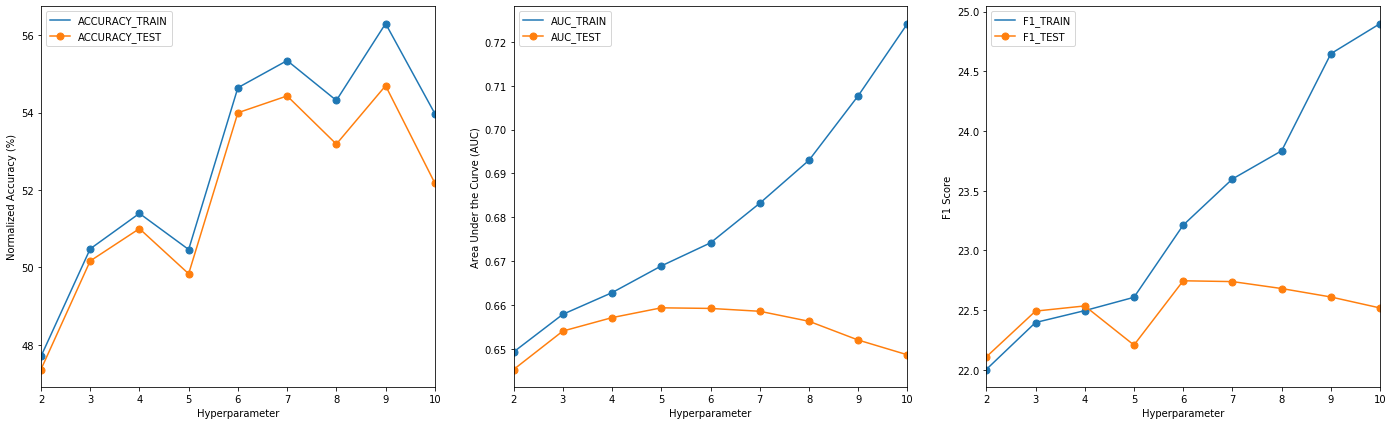

In [48]:
plot_train_test_curves(dt_performance_monthly, 'MAX_DEPTH')

In [49]:
dt_performance_monthly

,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST,MAX_DEPTH
0,47.696349,47.358609,22.001986,22.107186,0.128501,0.790647,0.649271,0.645267,2
1,50.476951,50.164028,22.395478,22.491034,0.131827,0.765279,0.657857,0.654036,3
2,51.393328,50.999298,22.495030,22.534376,0.132457,0.754324,0.662799,0.657102,4
3,50.460004,49.832946,22.606755,22.206788,0.130094,0.757848,0.668893,0.659336,5
4,54.642408,53.994770,23.211395,22.745106,0.135172,0.716784,0.674161,0.659198,6
5,55.343308,54.429353,23.597879,22.738281,0.135377,0.709737,0.683196,0.658547,7
6,54.313142,53.184316,23.834030,22.680062,0.134368,0.726714,0.692999,0.656263,8
7,56.299632,54.693855,24.647241,22.609361,0.134803,0.700448,0.707718,0.651982,9
8,53.972981,52.175939,24.899265,22.517284,0.132936,0.735490,0.724168,0.648610,10


#### <div style='color:purple'>By looking at the AUC curves and F1 score curves for both training and test dataset: when max_depth=5 and 6, the AUC_TEST has the highest scores and two values are very closed to each other and the curve starts to decrease as the tree gets deeper which means the overfitting problem starts to show. However, by looking at the F1 score curve, at max_depth=5, the test F1 score for that point is the lowest. Therefore, max_depth=6 is better.

The indices for top 2 features are:  [14 16]


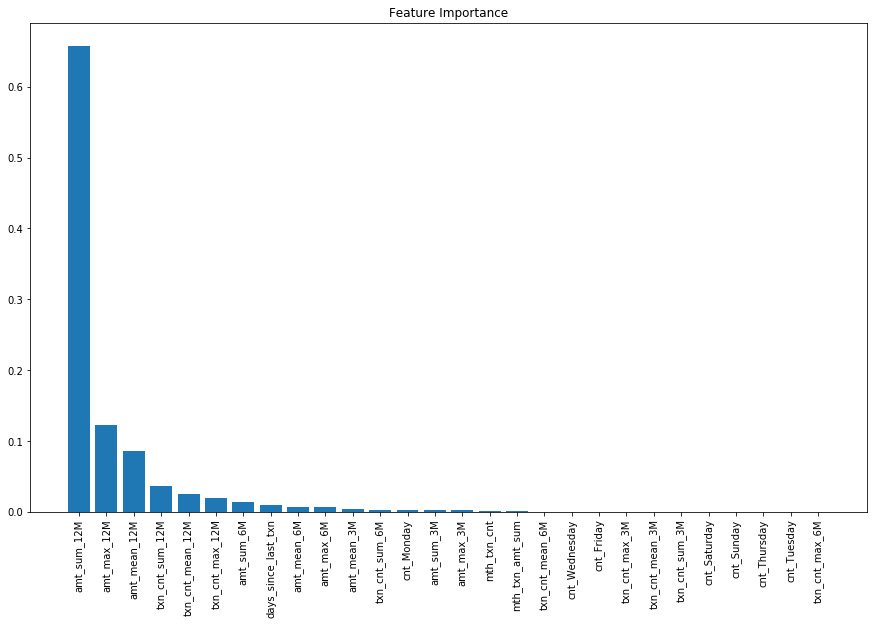

In [50]:
best_model, y_test_pred, y_test_prob, scores_train, scores_test = dt(X_train_monthly_scaled, X_test_monthly_scaled, y_train_monthly, y_test_monthly, X_train_monthly, 6)

Precision: 0.1352232784548672
Recall 0.7171684817424727

Top 2 features are: Index(['amt_sum_12M', 'amt_max_12M'], dtype='object')


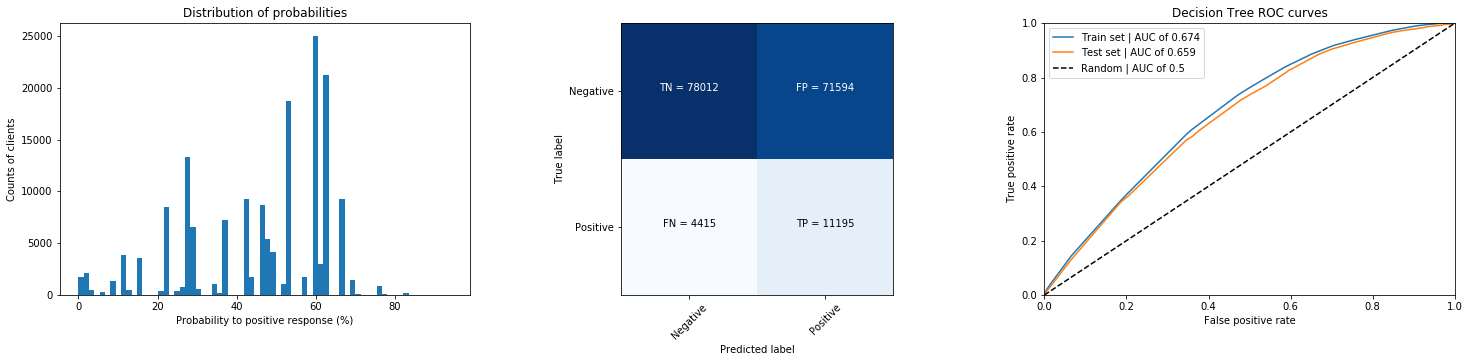

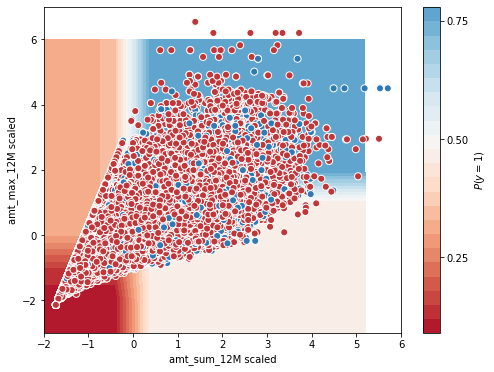

In [51]:
fig = plt.figure(figsize=(25,5))
fig.add_subplot(1,3,1)
plot_test_distribution(y_test_prob)

fig.add_subplot(1,3,2)
plot_confusion_matrix(y_test_monthly.values, y_test_pred)

fig.add_subplot(1,3,3)
plot_roc(y_train_monthly, scores_train, y_test_monthly, scores_test, 'Decision Tree')

plot_decision_boundary(best_model, 14,16, X_train_monthly_scaled, X_train_monthly, y_train_monthly)

### <center>Random Forest

In [52]:
rf_performance_monthly = find_best_rf(X_train_monthly_scaled, y_train_monthly, X_test_monthly_scaled, y_test_monthly)

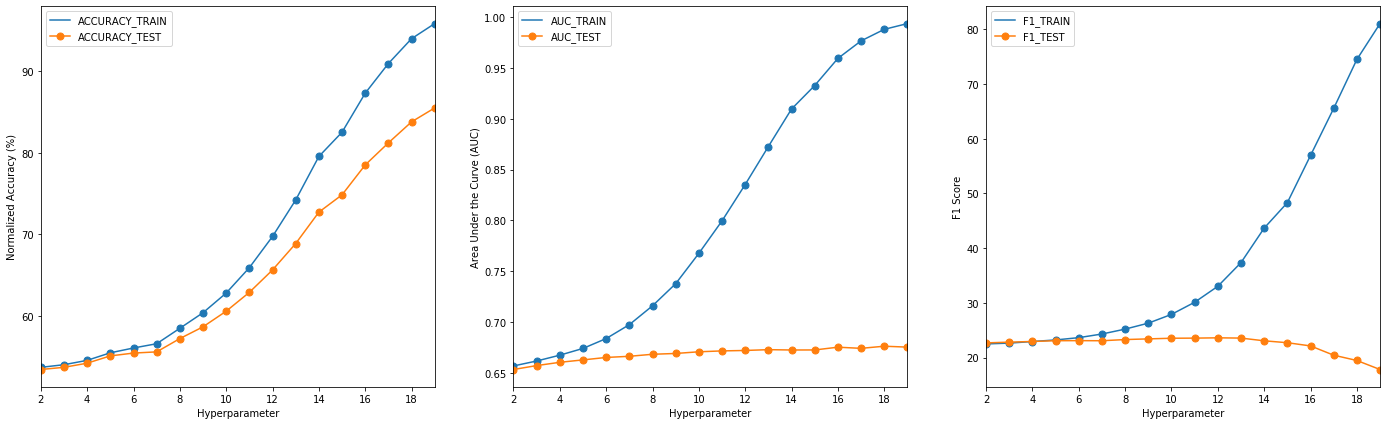

In [53]:
plot_train_test_curves(rf_performance_monthly, 'MAX_DEPTH')

In [54]:
rf_performance_monthly

,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST,MAX_DEPTH
0,53.700610,53.436713,22.490627,22.681863,0.134513,0.722870,0.657183,0.653688,2
1,54.025034,53.704242,22.638665,22.817356,0.135417,0.724279,0.662029,0.657539,3
2,54.558880,54.212062,22.932578,22.941602,0.136396,0.721397,0.667767,0.660757,4
3,55.483730,55.106043,23.221146,23.077242,0.137674,0.712748,0.674384,0.663123,5
4,56.073262,55.449835,23.640075,23.092034,0.137963,0.707880,0.684065,0.665516,6
5,56.595003,55.596916,24.306523,23.071841,0.137938,0.704741,0.697715,0.666654,7
6,58.487071,57.223877,25.201213,23.290749,0.140210,0.687316,0.716220,0.668647,8
7,60.394877,58.667441,26.291482,23.413037,0.141909,0.668674,0.737937,0.669433,9
8,62.805055,60.583115,27.893551,23.531346,0.144063,0.641896,0.767712,0.671087,10
9,65.917345,62.891609,30.113933,23.552003,0.146221,0.604997,0.799613,0.671945,11


#### <div style='color:purple'>By looking at the AUC curves and F1 score curves for both training and test dataset: when max_depth=12, F1 test has the highest score and AUC_TEST is second highest among other depth. As the tree get deeper and deeper, the F1 scores are decreasing and AUC_TEST has no significant improvements, therefore, max_depth=12 will be the best choice here.

The indices for top 2 features are:  [14 15]


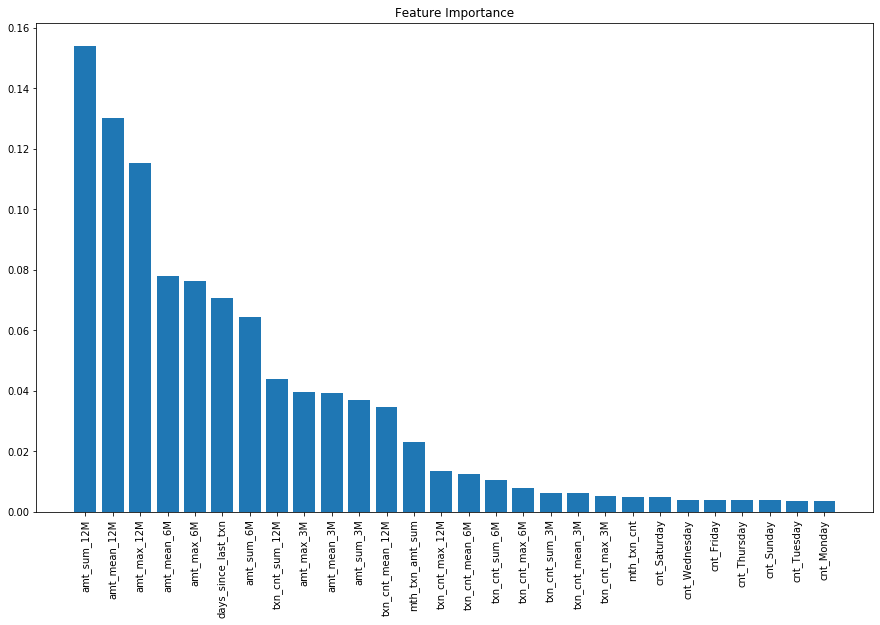

In [55]:
best_model, y_test_pred, y_test_prob, scores_train, scores_test = rf(X_train_monthly_scaled, X_test_monthly_scaled, y_train_monthly, y_test_monthly, X_train_monthly, 12)

Precision: 0.1494268535708811
Recall 0.562011531069827

Top 2 features are: Index(['amt_sum_12M', 'amt_mean_12M'], dtype='object')


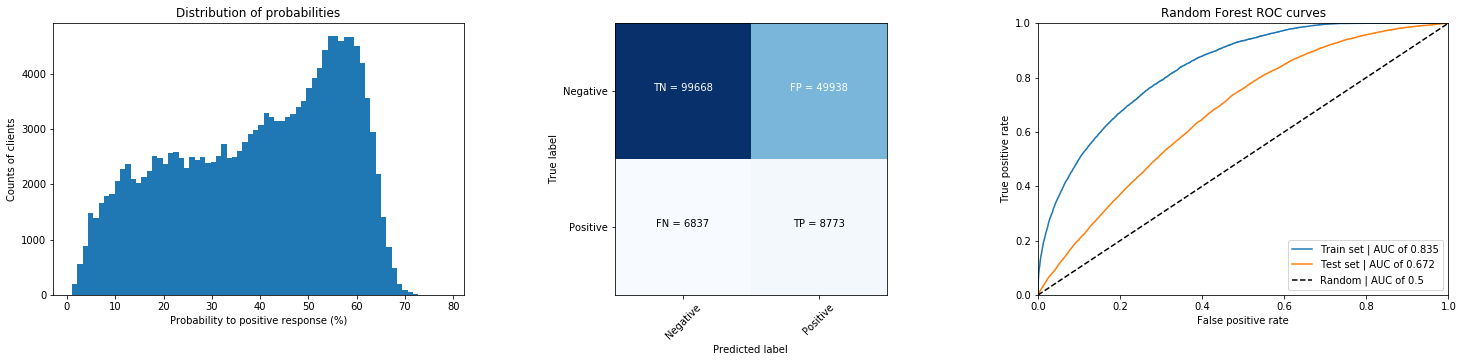

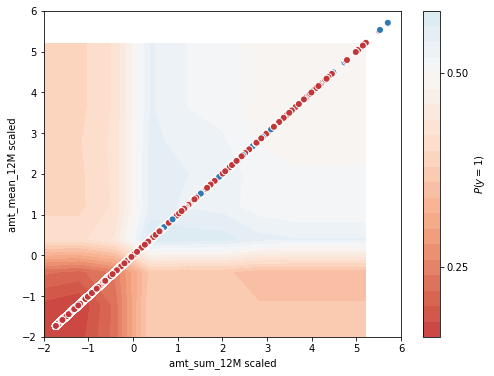

In [56]:
fig = plt.figure(figsize=(25,5))
fig.add_subplot(1,3,1)
plot_test_distribution(y_test_prob)

fig.add_subplot(1,3,2)
plot_confusion_matrix(y_test_monthly.values, y_test_pred)

fig.add_subplot(1,3,3)
plot_roc(y_train_monthly, scores_train, y_test_monthly, scores_test, 'Random Forest')

plot_decision_boundary(best_model, 14,15, X_train_monthly_scaled, X_train_monthly, y_train_monthly)

### 1.3 Comparison of Methods

### <center><div style='color:green'>Annual Dataset</div></center>

|# of Records|# of Features|# of Positive Responses|% of Positive Responses|
|- -- -------|- -- --------|- -- -------- ---------|- -- -------- ---------|
|6884|75|647|9.3%|



|Algorithms|Training Accuracy|Test Accuracy|Training F1|Test F1|Precision|Recall|Training AUC|Test AUC|Top 2 Features|Number of Important Features|Distribution|Number of TP|Number of FP|
|----------|-------- --------|---- --------|-------- --|---- --|---------|------|-------- ---|---- ---|--- - --------|------- ----------|------------|------ -- --|------ -- --|
|Logistic Regression|58.2|59.3|25.7|29.3|0.177|**0.858**|0.808|**0.765**|'ann_txn_amt_sum_2013','ann_txn_cnt_2014'|27|Dense, left skewed, the minimum is around 0 and maximum is around 100|**309**|1221|
|Decision Tree|72.1|70.4|31.6|30.4|0.198|0.659|0.784|0.742|'ann_txn_amt_sum_2014','ann_txn_amt_sum_2013'|5|Sparse, only shows 7 bars and the maximum is around 75%|297|1205|
|Random Forest|**76.9**|**73.7**|**37.8**|**30.5**|**0.206**|0.588|**0.901**|0.745|'ann_txn_amt_sum_2014','ann_txn_cnt_2014'|**ALL**|Dense, has three modals and the maximum is around 75%|265|**1019**|

### <center><div style='color:green'>Monthly Dataset</div></center>

|# of Records|# of Features|# of Positive Responses|% of Positive Responses|
|- -- -------|- -- --------|- -- -------- ---------|- -- -------- ---------|
|247824|28|23292|9.3%|



|Algorithms|Training Accuracy|Test Accuracy|Training F1|Test F1|Precision|Recall|Training AUC|Test AUC|Top 2 Features|Number of Important Features|Distribution|Number of TP|Number of FP|
|----------|-------- --------|---- --------|-------- --|---- --|---------|------|-------- ---|---- ---|--- - --------|------- ----------|------------|------ -- --|------ -- --|
|Logistic Regression|62.1|61.9|23.2|23.2|0.143|0.609|0.661|0.658|'amt_mean_12M','amt_sum_12M'|15|Dense, left skewed, maximum is around 90% and minimum is around 20%|9503|56910|
|Decision Tree|54.6|54.0|23.2|22.7|0.135|**0.718**|0.674|0.659|'amt_max_12M','amt_sum_12M'|12|Sparse, right skewed, minimum is around 0 and maximum is around 80%|**11195**|71594|
|Random Forest|**69.7**|**65.6**|**33.0**|**23.6**|**0.149**|0.562|**0.835**|**0.672**|'amt_mean_12M','amt_sum_12M'|**ALL**|Dense, right skewed, minimum is around 0 and maximum is aorund 72%|8773|**49938**|

### <center><div style='color:green'>Discussion</div></center>

- <b style='color:orange'>Comparing two feature engineering methods</b>: 

    - <b>Metrics</b>: The scores of all metrics from monthly features are lower than the ones from annual features. One of the reasons could be that monthly data has much more records and fewer features than the annual data as we can see the above tables, in this way, the models may not have learned enough information from the data, one way to improve this situation is to engineer more features for the monthly data that could allow the models to increase its predictive power. 
    
    - <b>Top 2 features</b>: By looking at the top 2 features, it clearly shows all models are favoring the long term indicators such as the annual sum/mean/count of all transactions in the annual models and 12-month indicators for sum/mean/max of transactions for 12 months which makes a lot of sense since the models captured the long term trend and will not be affected too much by outliers existing in short-term indicators.
    
    - <b>Number of Important Features</b>: By looking at the total number of features in two different datasets and their number of important features, it clearly shows that annual models has fewer percentage of important features than the monthly model, which means the annual dataset can used fewers features to get a better performance.
    
    - <b>Distribution</b>: The trend of all the distributions are very similar, logistic regression model has left skewed structure all the time and tree models are right skewed. However, by looking at the x-axis scales, it clearly shows that the annual models have larger probabilities in predicting positive responses such as logistic regression: the maximum probability from it using annual data is nearly 100% and minimum is 0% but monthly model has a range of 20%-90% which indicates annual data make the models more confident to predict the positive classes.
    
    - <b>Confusion Matrix</b>: By taking ratios of number of FP over the number of TP, we can clearly see the ratio is around 4 in the annual data and 6 in the monthly data, which means annual data has more true predictions and fewer wrong predictions.


- <b style='color:orange'>Comparing three models</b>: 

    - <b>Metrics</b>: Random forest has the best performance metrics in both annual and monthly data as shown in the tables above, and it has the least number of FALSE POSITIVES compared to other two models. 
    
    - <b>Features</b>: It is definitely worth to mention that random forest used information from all the features from the dataset as shown in the features importance plots as it can go really deep and aggregate multiple simple trees to a single final prediction, therefore, it has strong advantage of extracting information; on the other hand, logistic regression and decision tree onlu used a couple of features and regard most of the features as useless which could be a waste of information. 
    
    - <b>Confusion Matrix</b>: In annual data, logistic regression has the highest test AUC score and recall and the highest number of TRUE POSITIVE predictions; decision tree outperforms other two models in terms of TP in monthly data.
    
    - <b>Distribution</b>: In terms of test result distributions, decision tree has the sparse structure due to its nature and logistics regression is always left skewed which means most of its predictions are below 50% (class 0), however, random forest is opposite to logistic regression model which is more evenly distributed and a little bit right skewed which mean it predicted a lot of class 1 in the test data.
    
    
- <b style='color:red'>Choosing the best combination</b>: <u>Annual data with logistic regression model</u>.

    - For a promotion compaign, the main objective is to increase the ROI(return of investment) of the promotion activity which means that we want to engage more with those clients who responsed positively since we want them to make more transactions so that our ROI will be boosted. 
    - In terms of the model, we want to reduce the number of people who actually responded as positve but the model miscalssfied it as negative. The reason is that the cost of FN is actually very expensive since we will lose the opportunity to engage with those clients who actually are interested in our promotion campaign, however, on the other hand, it does not break the deal too much if we think some people are actually not interested are interested in out campaign. Therefore, we are more focusing on the recall of the model and want to make sure every single client who is actually interested will be engaged and correctly classified by our model. 
    - As the analysis above shows, annual data could help us more to know about the big picture of the profile of all clients instead of being influenced by small fluactuations and outliers in the monthly data and models will be more confident predicting the probabilities of the classes. Logistic regression in annual data gives us the best recall and AUC test socre and highest number of true positives, therefore, it can give us more confidence in engaging with the right clients and get higher ROI from this promotion campaign.